In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

df_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


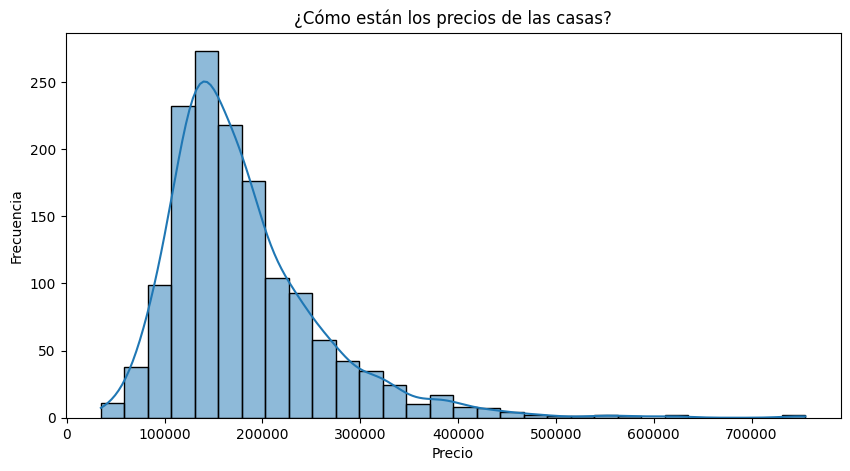

Casas baratas: menos de 101478.69300752433
Casas normales: entre 101478.69300752433 y 260363.69877329757
Casas caras: más de 260363.69877329757


In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['SalePrice'], bins=30, kde=True)
plt.title("¿Cómo están los precios de las casas?")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

mean_price = df_train['SalePrice'].mean()
std_price = df_train['SalePrice'].std()

low_price = mean_price - std_price
mid_price = mean_price + std_price

print(f"Casas baratas: menos de {low_price}")
print(f"Casas normales: entre {low_price} y {mid_price}")
print(f"Casas caras: más de {mid_price}")


Para definir si una casa es barata, normal o cara, se utilizó la **media y la desviación estándar** porque permiten capturar la tendencia central de los precios y su variabilidad. La media representa el precio promedio de las casas, mientras que la desviación estándar indica cuánto varían los precios respecto a ese promedio. Al clasificar las casas usando **(media - desviación estándar)** para económicas y **(media + desviación estándar)** para caras, se obtiene una separación basada en la dispersión natural de los datos, asegurando que las categorías reflejen diferencias significativas en el mercado.

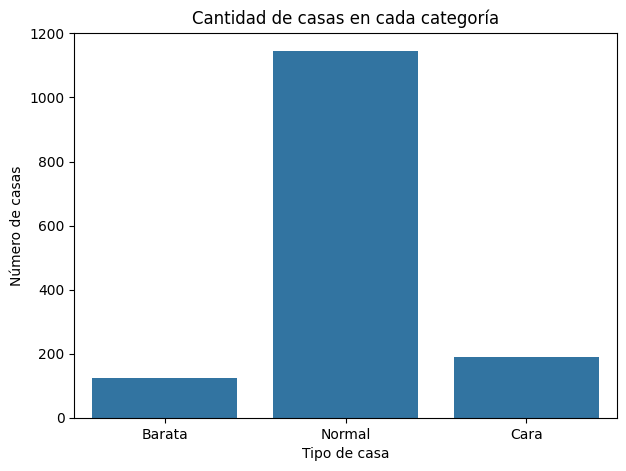

Categoria
Normal    1145
Cara       191
Barata     124
Name: count, dtype: int64

In [11]:
def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

df_train['Categoria'] = df_train['SalePrice'].apply(categorizar_casas)

plt.figure(figsize=(7, 5))
sns.countplot(x=df_train['Categoria'], order=["Barata", "Normal", "Cara"])
plt.title("Cantidad de casas en cada categoría")
plt.xlabel("Tipo de casa")
plt.ylabel("Número de casas")
plt.show()

df_train['Categoria'].value_counts()


Los resultados muestran que la mayoría de las casas (1145) fueron clasificadas como **normales**, mientras que hay pocas **baratas** (124) y **caras** (191). Esto significa que, con este método, la mayoría de los precios caen en la categoría intermedia, dejando pocas casas en los extremos. Puede ser que los valores de las casas no varíen tanto o que esta forma de clasificarlas no sea la mejor para repartirlas de manera más pareja. Si se quiere una distribución más equilibrada, quizás sería mejor usar otro criterio, como los percentiles.

In [12]:
columnas_utiles = ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt", "LotArea"]

X = df_train[columnas_utiles]
y = df_train["Categoria"]

# Categorica a numerica
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")


Tamaño del set de entrenamiento: (1168, 7)
Tamaño del set de prueba: (292, 7)


In [13]:
modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X_train, y_train)

score_train = modelo.score(X_train, y_train)
score_test = modelo.score(X_test, y_test)

print(f"Precisión en entrenamiento: {score_train:.2f}")
print(f"Precisión en prueba: {score_test:.2f}")


Precisión en entrenamiento: 0.88
Precisión en prueba: 0.86


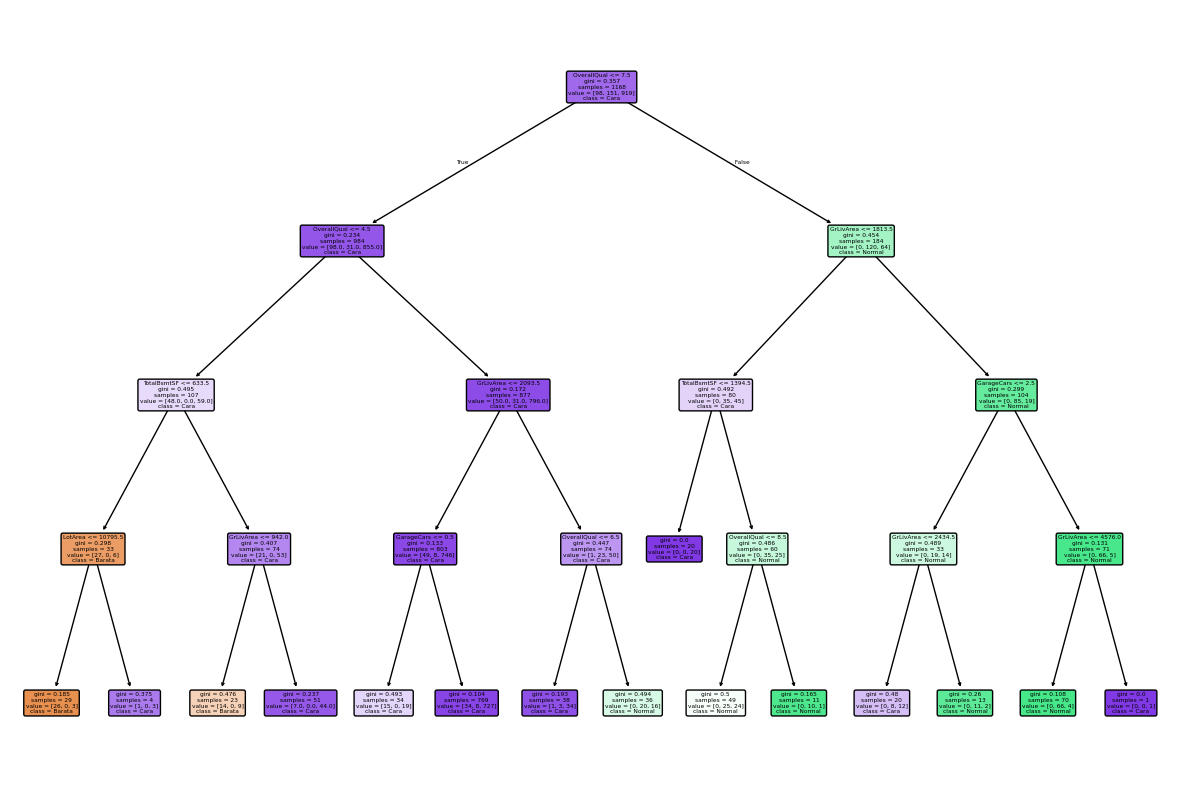

In [14]:
plt.figure(figsize=(15, 10))
plot_tree(modelo, feature_names=X.columns, class_names=["Barata", "Normal", "Cara"], filled=True, rounded=True)
plt.show()


## Evaluacion del modelo en el conjunto de prueba

In [15]:

y_pred = modelo.predict(X_test)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

      Barata       0.59      0.38      0.47        26
        Cara       0.77      0.82      0.80        40
      Normal       0.90      0.92      0.91       226

    accuracy                           0.86       292
   macro avg       0.75      0.71      0.72       292
weighted avg       0.85      0.86      0.86       292



El modelo tiene una precisión del **86%**, lo que significa que en general clasifica bien las casas. Sin embargo, no lo hace igual de bien en todas las categorías. Funciona muy bien con las casas **"Normales"**, donde acierta en la mayoría de los casos. También le va bastante bien con las casas **"Caras"**, aunque a veces las confunde con otras. 

El mayor problema está en las casas **"Baratas"**, donde el modelo se equivoca mucho. Solo acierta el **38%** de las veces cuando una casa realmente es barata, lo que indica que muchas son clasificadas como "Normales" o incluso "Caras". Esto puede ser porque hay pocas casas de este tipo en los datos o porque los límites de precio que usamos para definirlas no son los mejores. 

Para mejorar, podríamos **ajustar la forma en que clasificamos las casas**, por ejemplo, usando percentiles en lugar de la media y la desviación estándar. También podríamos **agregar más ejemplos de casas baratas** para que el modelo aprenda mejor a reconocerlas. Otra opción sería probar con un modelo más avanzado, como un **Random Forest**, que podría hacer un mejor trabajo al encontrar patrones en los datos.

## Análisis con la matriz de confusión

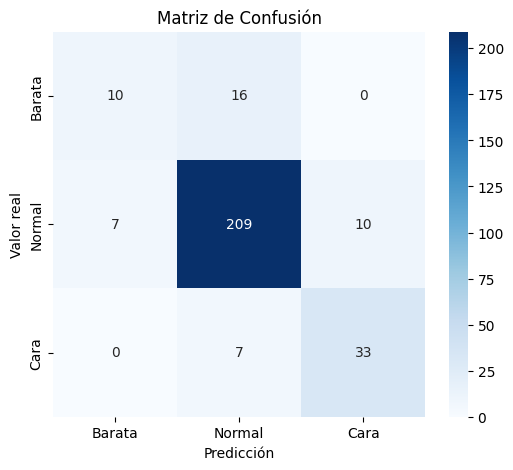

In [16]:

conf_matrix = confusion_matrix(y_test, y_pred, labels=["Barata", "Normal", "Cara"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Barata", "Normal", "Cara"], yticklabels=["Barata", "Normal", "Cara"])
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()


La matriz de confusión muestra que el modelo clasifica bien las casas **"Normales"**, con **209 aciertos**, pero tiene problemas con las **"Baratas"** y **"Caras"**. En el caso de las casas **"Baratas"**, solo acertó **10 veces**, mientras que en **16 casos** las confundió con casas "Normales". Esto confirma lo que vimos en el reporte de clasificación: el modelo tiene dificultad para identificar las casas más baratas.

Para las casas **"Caras"**, el modelo acertó **33 veces**, pero en **7 casos** las clasificó como "Normales". Este error es menos grave que el de las casas "Baratas", pero aún así muestra que hay margen de mejora. La principal confusión ocurre entre las categorías **"Barata" y "Normal"**, lo que podría indicar que los rangos de precios no están bien diferenciados o que las características elegidas no separan bien estas clases.

Para mejorar el modelo, podríamos **revisar cómo definimos las categorías de precios** (quizás usar percentiles en lugar de la media y desviación estándar). También sería útil **balancear los datos**, agregando más ejemplos de casas baratas para que el modelo aprenda mejor a diferenciarlas. Finalmente, probar un **modelo más avanzado** como Random Forest podría ayudar a reducir estos errores.